In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [29]:
device

device(type='cuda')

In [30]:

# image_path = "images/viking.jpg"
# img = Image.open(image_path)

# # Resize the image
# new_size = (512, 512)  # Set the desired width and height
# resized_img = img.resize(new_size)

# # Save the resized image in the working directory
# resized_img.save("images/viking1.jpg")

In [31]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("images/scary_nights1.jpg")
content_img = image_loader("images/cow-calf.jpg")#space1.png 
# content_img=content_img[:512][:512]

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

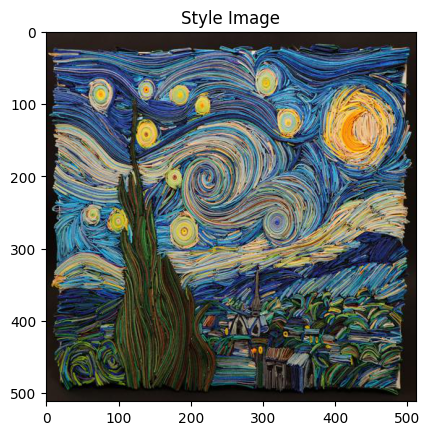

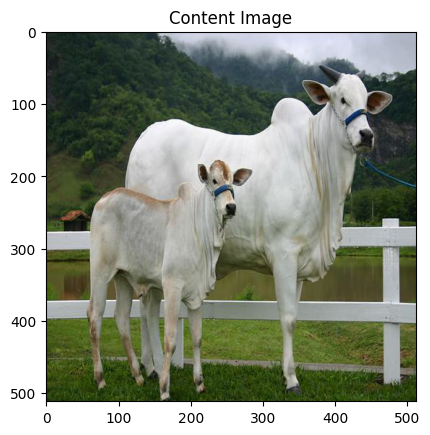

In [32]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# Defining Loss Functions 

## Content loss

The content loss is a function that represents a weighted version of the content distance for an individual layer. The function takes the feature maps F_XL of a layer L in a network processing input X and returns the weighted
content distance between the image X(received from the preseding layers) and content image(content target image). The feature maps of the content image must be known by the function in order to calculate the content distance. We implement this function as a torch module with a constructor that takes F_CL as an input. The mean square error between the two sets of feature maps(F_XL,F_CL) is computed using nn.MSELoss

Now, in order to make the content loss layer transparent we must define a forward method that computes the content loss and then returns the layer’s input. The computed loss is saved as a parameter of the module.


In [33]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used to dynamically compute the gradient: this is a stated
        # value, not a variable. This is for forward method of the criterion not to throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input 

## Style loss and Gram Matrix

The style loss module is implemented similarly to the content loss module. It will act as a transparent layer in a network that computes the style loss of that layer. In order to calculate the style loss,  we need to compute the gram matrixG_XL.A gram matrix is the result of multiplying a given matrix by its transposed matrix. In this application the given matrix is a reshaped version of the feature maps F_XL of layer L. F_XL is reshaped to form F_XLhat, a KxN matrix, where K is the number of feature maps at layer L and N is the length of any vectorized feature map  F_XLk.

In [34]:
def gram_matrix(input):
    a, b, c, d = input.size() 
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into F_XL hat

    G = torch.mm(features, features.t())  # computing the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [35]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Importing the CNN model 

Here, we are not training the model from scratch as we just need a good CNN model to give features. So, took existing pretrained VGG19 model from torch.

In [36]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Below cell we're defining class for  Normalization module which normalizes the input before feeding to the upcoming Modules defined in get_style_model_and_losses function

In [37]:
#VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
#We will use them to normalize the image before sending it into the network.
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

# Defining sequential module for processing images

A Sequential module contains an ordered list of child modules. For instance, vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted.

In [44]:
# desired depth layers to compute style/content losses
# Modify the layers to accumulate loss and experiment
content_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module/layer
    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    #``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``to put in modules that are supposed to be 
    #activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version didn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we inserted below. So we replace with out-of-place(inplace=False) ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    print(i)
    model = model[:(i + 1)]

    return model, style_losses, content_losses

LOADING INPUT IMAGE HERE

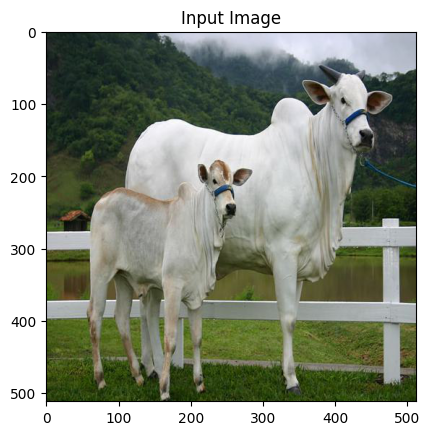

In [39]:


# input_img=image_loader("images/nature1.jpg")#space1.png picasso.jpg nature1.jpg houses1.png
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
# input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [40]:
def get_input_optimizer(input_img):
    # this line to show that input image pixels are the parameters that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

# Style adaptation

In [41]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=150,
                       style_weight=50000, content_weight=1):

    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
                # getting loss from style_loss module
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
20
Optimizing..
run [50]:
Style Loss : 5.799922 Content Loss: 59.750053

run [100]:
Style Loss : 3.858026 Content Loss: 55.812805

run [150]:
Style Loss : 3.379564 Content Loss: 55.663582



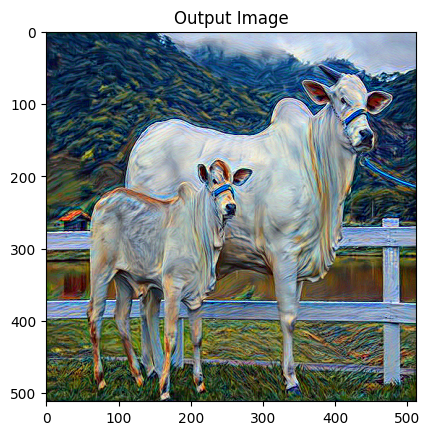

In [42]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()
# print()

# Evaluation

We can use ContentLoss and StyleLoss as evaluation metrics and for a given test image, we can see in outputs of above cell how it is changing and approximately adjust the parameters to get the image that visually looks good for us.

# Limitations and potential improvements of the model

Whatever the feature style are there in the style image, it gets applied througout the whole content image and we won't have control over which region of image do we want those changes to appear, in that way we can add many more  different features from different style images thus getting more stylized image. In my approach I took Input image as same as content image. It would be better if we can mix features of one image and contents of another image into Main image(say).